In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pytse_client as tse
from pytse_client.download import download_financial_indexes

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from zigzag import peak_valley_pivots

In [3]:
#sipa = tse.download(symbols = ["خساپا"], write_to_csv = False, include_jdate = True)
#marketIndex = download_financial_indexes(symbols = "شاخص كل", write_to_csv = False, include_jdate = True)

tse.download(symbols = ['فولاد'], write_to_csv = True, include_jdate = True)
folad = tse.Ticker(symbol = 'فولاد',  adjust = True)
foladHist = folad.history
foladHist.insert(1,'step', np.arange(1, len(foladHist) + 1)) 
foladHist

,date,step,open,high,low,adjClose,value,volume,count,yesterday,close
0,2007-03-11,1,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,2007-03-12,2,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,2007-03-13,3,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,2007-03-14,4,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,2007-03-17,5,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
3397,2022-08-17,3398,5600.0,5650.0,5500.0,5560.0,423917045370,76206181,5200,5600.0,5540.0
3398,2022-08-21,3399,5420.0,5450.0,5400.0,5420.0,351314262970,64793800,2068,5560.0,5430.0
3399,2022-08-22,3400,5420.0,5420.0,5240.0,5310.0,621874298380,117052411,8497,5420.0,5290.0
3400,2022-08-23,3401,5230.0,5340.0,5220.0,5270.0,329122689880,62393229,6703,5310.0,5280.0


In [3]:
# سرانه خرید هر حقیقی، سرانه فروش هر حقیقی، نسبت سرانه خرید حقیقی به فروش حقیقی، ورود و یا خروج پول حقیقی
# و میانگین متحرک سی روزه تمام بالایی
folad.client_types

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,20220824,2433,6,1074,20,64053172,4646244,30822456,37876960,341124731740,24763337000,164155081290,201732987450,5325.649317,5325.827419,5329.753883,5326.007881,33230716.0
1,20220823,3106,9,1543,16,58082075,4311154,51648211,10745018,306312873330,22809816550,272453128290,56669561590,5273.793564,5275.170679,5290.884192,5274.031332,6433864.0
2,20220822,3142,14,2325,19,53617738,63434673,90419949,26632462,284791650860,337082647520,480526551820,141347746560,5311.519312,5314.386450,5313.854893,5307.348099,-36802211.0
3,20220821,804,5,543,13,14613369,50180431,29272091,35521709,79223308920,272090954050,158710993540,192603269430,5421.289842,5421.921978,5422.252233,5422.128463,-14658722.0
4,20220817,2182,6,1255,13,35782991,40423190,36732725,39473456,198581293870,225335751500,204119827160,219797218210,5549.600196,5556.893129,5574.417840,5568.228386,-949734.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,20081202,7,1,1,0,18553,10000,28553,0,43358361,23370000,66728361,0,2337.000000,2337.000000,2337.000000,NaN,-10000.0
3013,20081201,8,1,5,1,128666,10,128666,10,300821108,24090,300821108,24090,2338.000000,2338.000000,2409.000000,2409.000000,0.0
3014,20081130,10,2,1,1,87219,12791,100000,10,204005241,29918859,233900000,24100,2339.000000,2339.000000,2339.055508,2410.000000,-12781.0
3015,20081129,116,175,3,2,4718258,33691903,121402,38288759,14980229312,107713006031,284080680,122409154663,3174.949168,2340.000000,3196.999767,3196.999795,4596856.0


# ZigZag

In [60]:
pivots = peak_valley_pivots(foladHist['adjClose'], 0.1, -0.1)
foladHist['label'] = pivots
foladHist.head()
foladHist['label'].value_counts()

 0    3305
-1      49
 1      48
Name: label, dtype: int64

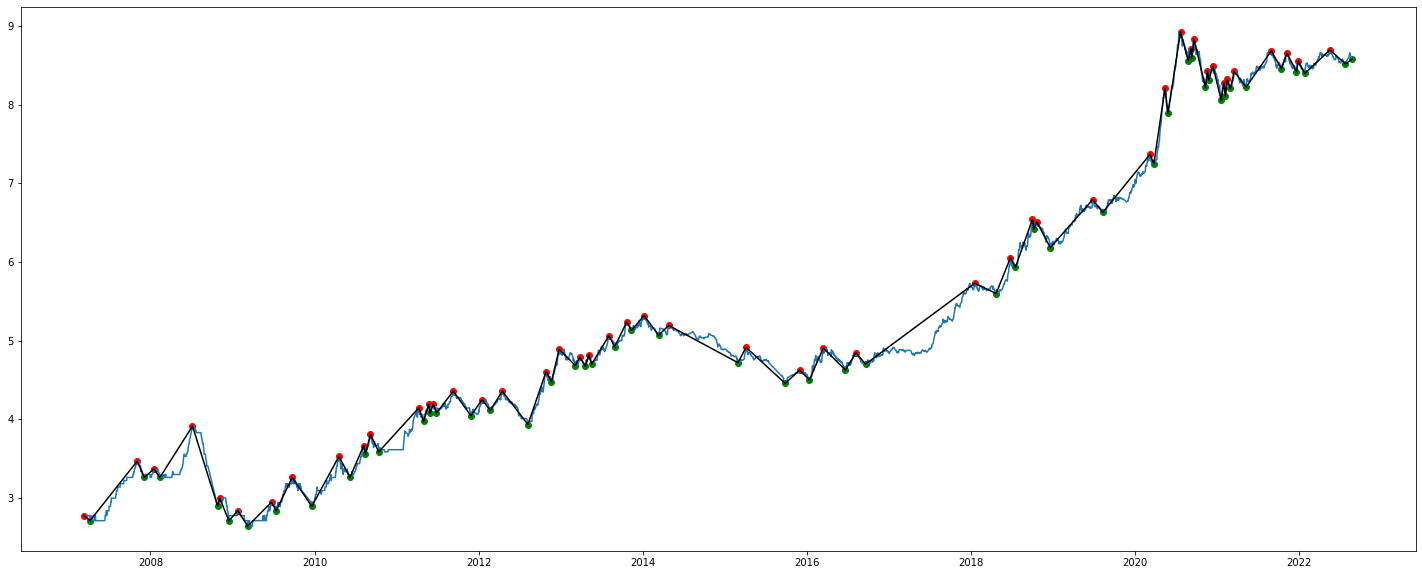

In [20]:
plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][pivots != 0], np.log(foladHist['adjClose'][pivots != 0]), 'k-')
plt.scatter(foladHist['date'][pivots == 1], np.log(foladHist['adjClose'][pivots == 1]), color='r')
plt.scatter(foladHist['date'][pivots == -1], np.log(foladHist['adjClose'][pivots == -1]), color='g')

# Rolling

In [6]:
window = 100
foladHist['rolling lable'] = 0

foladMax = foladHist['adjClose'].rolling(window = window, min_periods = 5).max()
foladHist.loc[foladMax == foladHist['adjClose'], 'rolling lable'] = -1

foladMin = foladHist['adjClose'].rolling(window = window, min_periods = 5).min()
foladHist.loc[foladMin == foladHist['adjClose'], 'rolling lable'] = 1

foladHist

,date,open,high,low,adjClose,value,volume,count,yesterday,close,rolling lable
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,0
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,0
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,0
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,0
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,1
...,...,...,...,...,...,...,...,...,...,...,...
3397,2022-08-17,5600.0,5650.0,5500.0,5560.0,423917045370,76206181,5200,5600.0,5540.0,0
3398,2022-08-21,5420.0,5450.0,5400.0,5420.0,351314262970,64793800,2068,5560.0,5430.0,0
3399,2022-08-22,5420.0,5420.0,5240.0,5310.0,621874298380,117052411,8497,5420.0,5290.0,0
3400,2022-08-23,5230.0,5340.0,5220.0,5270.0,329122689880,62393229,6703,5310.0,5280.0,0


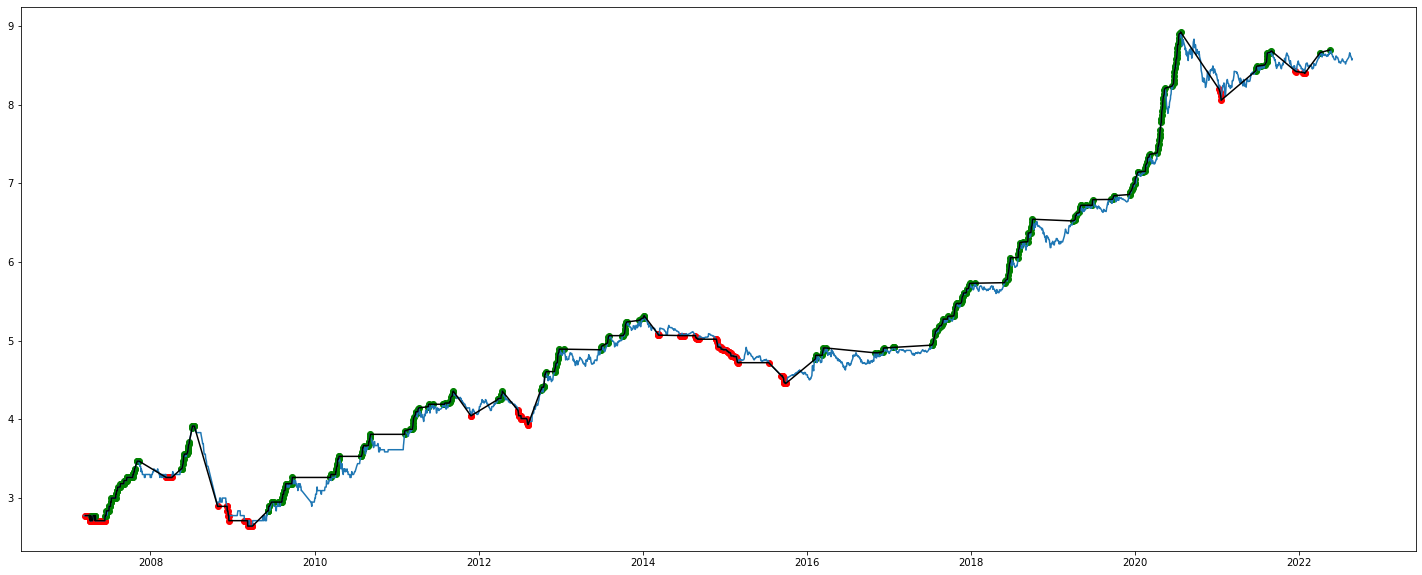

In [7]:
plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][foladHist['rolling lable'] != 0], np.log(foladHist['adjClose'][foladHist['rolling lable'] != 0]), 'k-')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == 1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == 1]), color='r')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == -1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == -1]), color='g')

# Model

In [34]:
X = foladHist.iloc[:, 1:-1]
y = foladHist.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    shuffle = False,
    random_state = 0
)

In [40]:
rfc = RandomForestClassifier(
    n_estimators = 10, 
    criterion = 'entropy', 
    random_state = 0)

rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [58]:
y_test.value_counts()

 0    819
-1     17
 1     15
Name: label, dtype: int64

<AxesSubplot:>

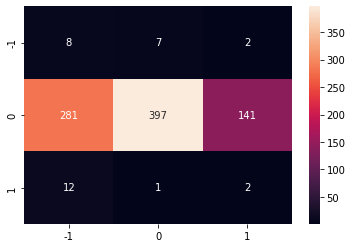

In [57]:
y_pred = rfc.predict(X_test)

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot = True,
    fmt = 'g',
    xticklabels = [-1, 0, 1], 
    yticklabels = [-1, 0, 1]
)

In [8]:
fig = make_subplots(
    rows = 2, 
    cols = 1, 
    shared_xaxes = True, 
    vertical_spacing = 0.03, 
    subplot_titles = ('OHLC', 'Volume'), 
    row_width = [0.2, 0.7]
)

fig.add_trace(
    go.Candlestick(
        x = foladHist['date'],
        open = foladHist['open'],
        high = foladHist['high'],
        low = foladHist['low'],
        close = foladHist['adjClose']
    ),
    row = 1, col = 1
)

fig.add_trace(
    go.Bar(
        x = foladHist['date'],
        y = foladHist['volume'], 
        showlegend = False
        ),
        row = 2, col = 1
)
fig.update(layout_xaxis_rangeslider_visible = False)
fig.show()